In [1]:
!pip install umap-learn rdkit

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
import torch
import umap
from mpl_toolkits.mplot3d import Axes3D
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.metrics import silhouette_score
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Specify the path to the BindingDB dataset file
file_path = '/content/drive/MyDrive/CS401/BindingDB_All.tsv'
list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)',
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9',
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']
data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])
df = pd.DataFrame(data)
df.head()

<ipython-input-4-43b04b325458>:8: DtypeWarning: Columns (8,9,10,11,12,13,15,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,...,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have information about Ki more than Kd in the dataset.

In [5]:
# Drop rows that contain any NaN value
df_cleaned = data.dropna(subset= ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)'], how = 'any')
df_cleaned.reset_index()

,index,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),...,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444348,2913146,NOCc1ccc(cc1)S(N)(=O)=O,Carbonic anhydrase 12,Homo sapiens,5400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444349,2913147,CC(=O)Nc1nnc(s1)S(N)(=O)=O,Carbonic anhydrase 12,Homo sapiens,5.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444350,2913148,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...,Carbonic anhydrase 12,Homo sapiens,9600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444351,2913149,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...,Carbonic anhydrase 12,Homo sapiens,14000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# HIV1 targeting coumpunds
hiv_data = df_cleaned[df_cleaned['Target Source Organism According to Curator or DataSource'].str.contains("Human immunodeficiency virus 1", case=False, na=False)].copy()
print(hiv_data.shape)

(4350, 25)


Number of targets of the comounds in HIV1:  126


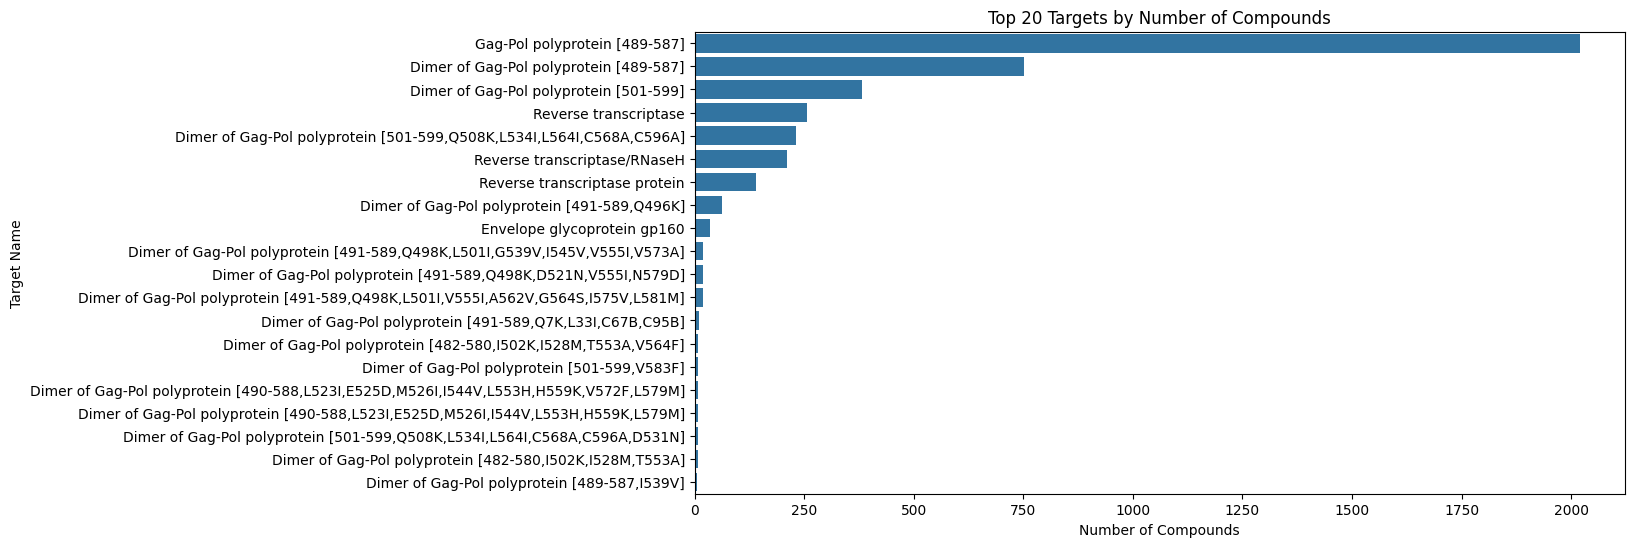

In [7]:
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the comounds in HIV1: ', target_counts.size)

plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20))
plt.title('Top 20 Targets by Number of Compounds')
plt.xlabel('Number of Compounds')
plt.ylabel('Target Name')
plt.show()

In [8]:
# Assuming the DataFrame 'hiv_data' with a column 'Ligand SMILES' is already prepared
smiles = hiv_data['Ligand SMILES']
smiles_list = list(set(smiles.to_list()))

## Embeddings

In [9]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
embeddings = np.zeros((len(smiles_list), 768))

for i in range(len(smiles_list)):
  inputs = tokenizer(smiles_list[i], padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  if i % 100 == 0:
    print(i)
  embeddings[i] = outputs.last_hidden_state.mean(dim=1).numpy()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


## UMAP

In [18]:
# Perform UMAP on embeddings
umap_ = umap.UMAP(n_components=3)
umap_embeddings = umap_.fit_transform(embeddings)

## KMeans

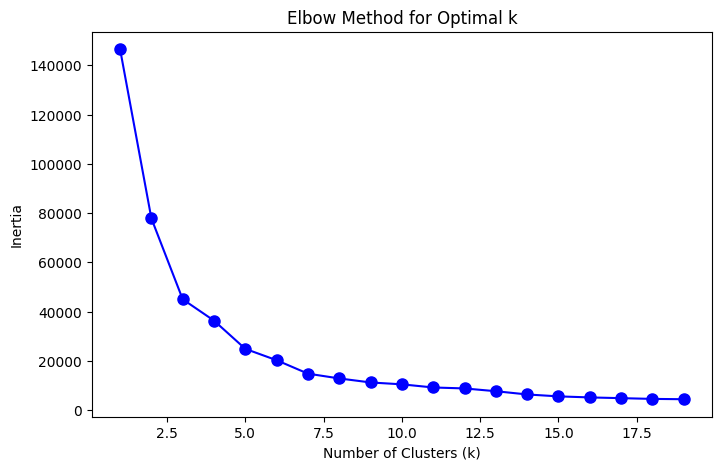

In [19]:
inertia = []
silhouette_scores = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    # Calculate the silhouette score, only works for k > 1
    if k > 1:
      s = silhouette_score(umap_embeddings, cluster_labels)
      silhouette_scores.append(s)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

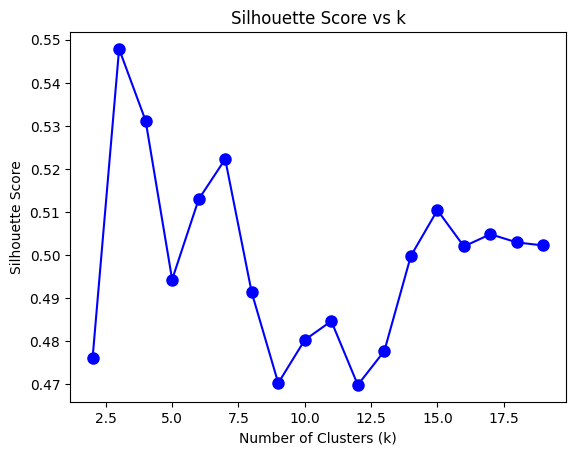

In [20]:
plt.plot(K[1:], silhouette_scores, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embeddings)

In [22]:
reducer = umap.UMAP(n_components=4)
data_3d = umap_embeddings
df = pd.DataFrame(data_3d, columns=['Component 1', 'Component 2', 'Component 3'])
df['Cluster'] = cluster_labels

fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3', color='Cluster',
                    title='3D UMAP Visualization with Clusters',
                    color_continuous_scale='Viridis')

fig.update_traces(marker=dict(size=5))
fig.show()

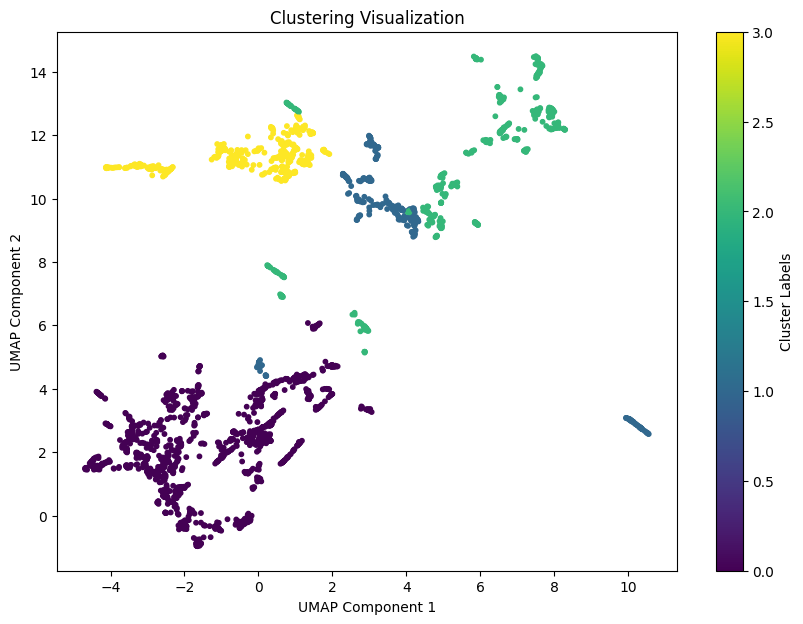

In [23]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster Labels')
plt.title('Clustering Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()